In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/2008.csv')

In [4]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,N612SW,88.0,90.0,78.0,-6.0,-4.0,IND,BWI,515,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


In [4]:
df['FlightNum'].dtype

dtype('int64')

In [17]:
stand = (df['UniqueCarrier'] == 'WN') & (df['FlightNum'] == 926) & (df['Origin'] == 'SJC') & (df['Dest'] == 'PHX')
df[stand]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
2414044,2008,5,10,6,1814.0,1815,1954.0,2010,WN,926,N368SW,100.0,115.0,91.0,-16.0,-1.0,SJC,PHX,621,3.0,6.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN


In [18]:
count_flights = df['Origin'].value_counts()

In [19]:
count_flights

ATL    414513
ORD    350380
DFW    281281
DEN    241443
LAX    215608
PHX    199408
IAH    185172
LAS    172876
DTW    161989
SFO    140587
SLC    139088
EWR    138506
MCO    130872
MSP    130289
CLT    126045
LGA    119135
JFK    118804
BOS    117915
SEA    109069
BWI    104074
PHL    100499
SAN     93775
CVG     91265
MDW     87619
DCA     86662
MEM     80966
TPA     78179
IAD     76031
FLL     67177
CLE     65795
        ...  
OTH       515
LMT       511
SLE       486
ACK       457
STX       436
MKG       396
YKM       340
ALO       323
CMX       318
RFD       290
BPT       276
WYS       264
PLN       264
RHI       221
TEX       194
LWB       185
HTS       158
ITH       132
SUX       122
BLI       120
AKN       116
DLG       116
ACY       116
ADK       102
GST        85
BJI        74
INL        72
TUP        10
PIR         5
PUB         2
Name: Origin, Length: 303, dtype: int64

In [20]:
airports = pd.read_csv('data/airports.dat', header = None, 
                   names = ['index', 'name', 'city', 'country', 'IATA', 'ICAO', 
                            'latitude', 'longitude', 'altitude', 'time zone', 
                            'DST', 'Tz database time zone', 'type', 'source'])

In [21]:
USA_airport = airports[(airports['country'] == 'United States')&(airports['IATA'] != '\\N')][['IATA','latitude','longitude']]

In [22]:
USA_airport.head()

,IATA,latitude,longitude
3211,BTI,70.134003,-143.582001
3213,LUR,68.875099,-166.110001
3214,PIZ,69.732903,-163.005005
3215,ITO,19.721399,-155.048004
3216,ORL,28.545500,-81.332901


In [ ]:
change_latitude = dep_latitude - arr_latitude
change_longitude = dep_longitude - arr_longitude
mid_change_latitude = mid_latitude - dep_latitude
mid_change_longitude = mid_longitude - dep_longitude

if (mid_change_latitude * change_latitude > 0) or (mid_change_longitude * change_longitude > 0):
    
def total_dist(dep, mid, arr):
    #genertae latitude and longitude first.
    
    diffLatitude_1 = math.radians(dep_latitude - mid_latitude)
    diffLongitude_1 = math.radians(dep_longitude - mid_longitude)
    diffLatitude_2 = math.radians(mid_latitude - arr_latitude)
    diffLongitude_2 = math.radians(mid_longitude - arr_longitude)
    a_1 = math.sin(diffLatitude_1/2) * math.sin(diffLatitude_1/2) + \
    math.cos(math.radians(dep_latitude)) * \
    math.cos(math.radians(mid_latitude)) * \
    math.sin(diffLongitude_1/2) * math.sin(diffLongitude_1/2)
    d_1 = 2 * math.asin(math.sqrt(a_1))
    a_2 = math.sin(diffLatitude_2/2) * math.sin(diffLatitude_2/2) + \
    math.cos(math.radians(mid_latitude)) * \
    math.cos(math.radians(arr_latitude)) * \
    math.sin(diffLongitude_2/2) * math.sin(diffLongitude_2/2)
    d_2 = 2 * math.asin(math.sqrt(a_2))
    total_d = d_1 + d_2
    return total_d

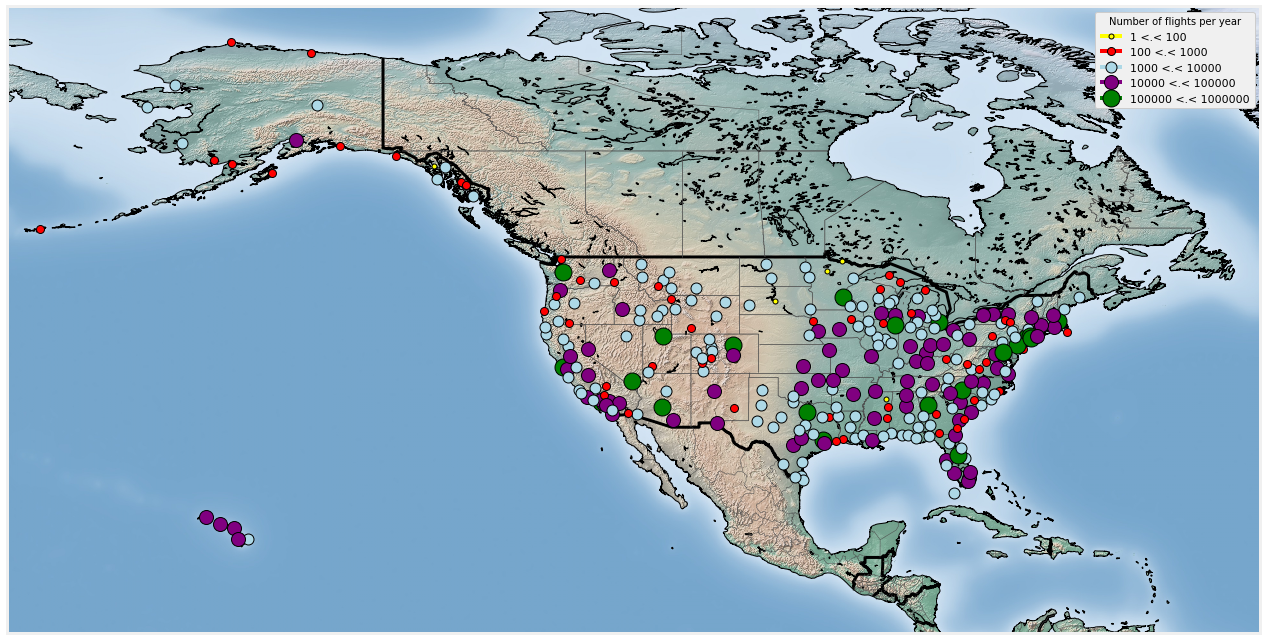

In [57]:
plt.figure(figsize=(20,20))
#________________________________________
# define properties of markers and labels
colors = ['yellow', 'red', 'lightblue', 'purple', 'green']
size_limits = [1, 100, 1000, 10000, 100000, 1000000]
label_flight = []
for i in range(len(size_limits)-1):
    label_flight.append("{} <.< {}".format(size_limits[i], size_limits[i+1])) 
#____________________________________________________________
map = Basemap(resolution='i',llcrnrlon=-180, urcrnrlon=-50,
              llcrnrlat=10, urcrnrlat=75, lat_0=0, lon_0=0,)
map.shadedrelief()
map.drawcoastlines()
map.drawcountries(linewidth = 3)
map.drawstates(color='0.3')
#_____________________
# put airports on map
for index, (code, y,x) in USA_airport[['IATA', 'latitude', 'longitude']].iterrows():
    if code in count_flights:   
        x, y = map(x, y)
        isize = [i for i, val in enumerate(size_limits) if val < count_flights[code]]
        ind = isize[-1]
        map.plot(x, y, marker='o', markersize = 3*ind+5, markeredgewidth = 1, color = colors[ind],
                 markeredgecolor='k', label = label_flight[ind])
#_____________________________________________
# remove duplicate labels and set their order
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('1 <.< 100', '100 <.< 1000', '1000 <.< 10000',
             '10000 <.< 100000', '100000 <.< 1000000')
new_label = OrderedDict()
for key in key_order:
    new_label[key] = by_label[key]
plt.legend(new_label.values(), new_label.keys(), loc = 1, prop= {'size':11},
           title='Number of flights per year', frameon = True, framealpha = 1)
plt.show()

In [18]:
'PUB' in count_flights

True

In [23]:
count_carrier = df['UniqueCarrier'].value_counts()

In [24]:
count_carrier

WN    1201754
AA     604885
OO     567159
MQ     490693
US     453589
DL     451931
UA     449515
XE     374510
NW     347652
CO     298455
EV     280575
9E     262208
FL     261684
YV     254930
OH     197607
B6     196091
AS     151102
F9      95762
HA      61826
AQ       7800
Name: UniqueCarrier, dtype: int64

In [25]:
airlines_names = pd.read_csv('data/airlines.csv')

In [26]:
airlines_names = airlines_names[['IATA_CODE', 'AIRLINE']]

In [27]:
airlines_names

,IATA_CODE,AIRLINE
0,9E,Pinnacle Airlines
1,AA,American Airlines
2,AQ,Aloha
3,AS,Alaska Airlines
4,B6,JetBlue Airways
5,CO,Continental Airlines
6,DH,Atlantic Coast Airlines
7,DL,Delta Air Lines
8,EV,Atlantic Southeast Airlines
9,F9,Frontier


In [32]:
for i, (code, airline) in airlines_names.iterrows():
    if code not in count_carrier:
        airlines_names.drop(axis=0, index = i,inplace=True)

In [33]:
airlines_names

,IATA_CODE,AIRLINE
0,9E,Pinnacle Airlines
1,AA,American Airlines
2,AQ,Aloha
3,AS,Alaska Airlines
4,B6,JetBlue Airways
5,CO,Continental Airlines
7,DL,Delta Air Lines
8,EV,Atlantic Southeast Airlines
9,F9,Frontier
10,FL,AirTran Airways


In [34]:
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

In [35]:
abbr_companies

{'9E': 'Pinnacle Airlines',
 'AA': 'American Airlines',
 'AQ': 'Aloha',
 'AS': 'Alaska Airlines',
 'B6': 'JetBlue Airways',
 'CO': 'Continental Airlines',
 'DL': 'Delta Air Lines',
 'EV': 'Atlantic Southeast Airlines',
 'F9': 'Frontier',
 'FL': 'AirTran Airways',
 'HA': 'Hawaiian Airlines',
 'MQ': 'American Eagle',
 'NW': 'Northwest Airlines',
 'OH': 'Comair',
 'OO': 'SkyWest Airlines',
 'UA': 'United Airlines',
 'US': 'US Airways',
 'WN': 'Southwest Airlines',
 'XE': 'ExpressJet Airlines',
 'YV': 'Mesa Airlines'}

In [36]:
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean(), 'delay percentage': (group>15).mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['DepDelay'].groupby(df['Origin']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('delay percentage')
global_stats

,count,delay percentage,max,mean,min
Origin,,,,,
TUP,10.0,0.000000,11.0,-3.800000,-14.0
INL,71.0,0.013889,23.0,-4.802817,-15.0
BLI,119.0,0.016667,107.0,-5.529412,-19.0
WYS,263.0,0.018939,96.0,-6.155894,-21.0
BJI,73.0,0.040541,139.0,-2.698630,-17.0
PIH,1639.0,0.040989,331.0,-4.150092,-30.0
BTM,690.0,0.043785,161.0,-2.878261,-25.0
HTS,155.0,0.044304,130.0,-1.141935,-10.0
IYK,916.0,0.046973,767.0,-1.911572,-24.0


In [37]:
global_stats['delay percentage']

Origin
TUP    0.000000
INL    0.013889
BLI    0.016667
WYS    0.018939
BJI    0.040541
PIH    0.040989
BTM    0.043785
HTS    0.044304
IYK    0.046973
COD    0.053030
BPT    0.054348
PSC    0.055490
YKM    0.058824
LWS    0.059816
CDC    0.059880
EKO    0.060127
OXR    0.060372
SUN    0.061303
ALO    0.061920
PLN    0.064394
RFD    0.065517
SGU    0.068695
LIH    0.070464
GTF    0.072897
SLE    0.074074
ITO    0.074401
FCA    0.077842
IPL    0.077856
OGG    0.079188
KOA    0.081511
         ...   
EGE    0.209594
SBN    0.209814
GST    0.211765
MOD    0.216774
ASE    0.216883
HOU    0.219834
SFO    0.221585
CDV    0.222069
PMD    0.222527
DFW    0.226606
JNU    0.229025
CIC    0.232040
ACV    0.232364
PSG    0.236589
RDD    0.241974
SPI    0.243265
MIA    0.261673
LMT    0.264188
ORD    0.265052
EWR    0.269144
STX    0.275229
EYW    0.275520
OTH    0.306796
ACK    0.336980
BRW    0.340659
CEC    0.342427
ADK    0.362745
DLG    0.456897
AKN    0.465517
PUB    0.500000
Name: delay perce

In [40]:
count_delay = global_stats['delay percentage']

In [38]:
#________________________________________
# define properties of markers and labels
colors = ['yellow', 'red', 'lightblue', 'purple', 'green', 'orange', 'black']
size_limits = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.51]
label_delay_new = []
for i in range(len(size_limits)-1):
    label_delay_new.append("{} <.< {}".format(size_limits[i], size_limits[i+1])) 

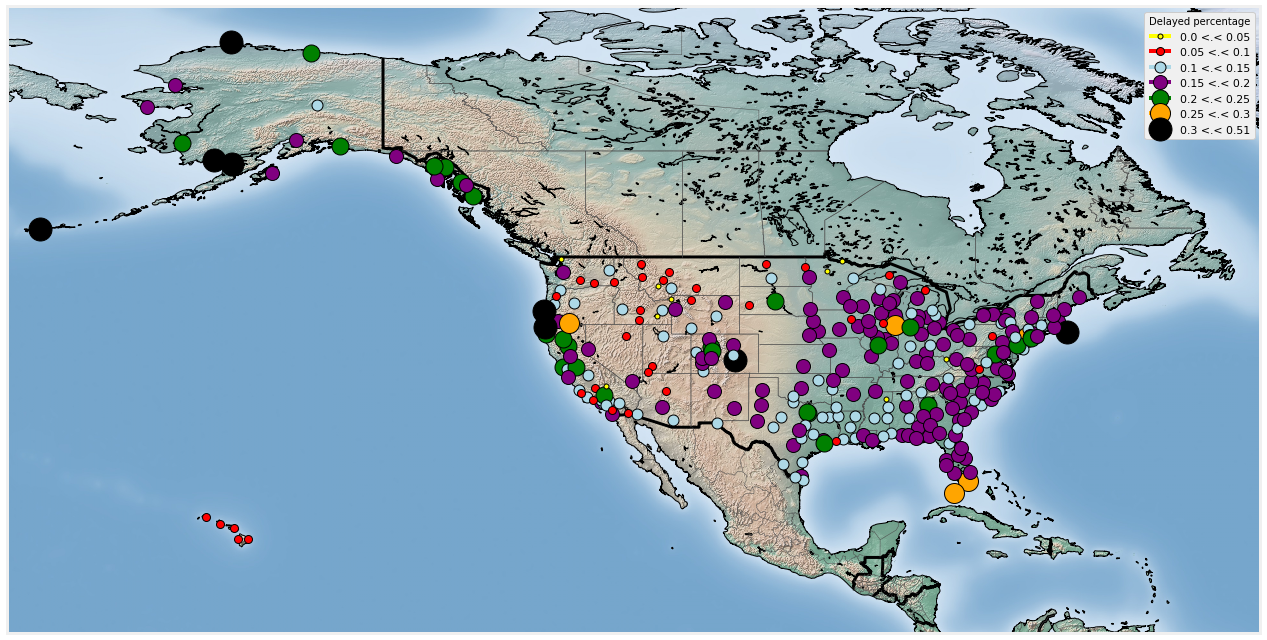

In [41]:
plt.figure(figsize=(20,20))
#____________________________________________________________
map = Basemap(resolution='i',llcrnrlon=-180, urcrnrlon=-50,
              llcrnrlat=10, urcrnrlat=75, lat_0=0, lon_0=0,)
map.shadedrelief()
map.drawcoastlines()
map.drawcountries(linewidth = 3)
map.drawstates(color='0.3')
#_____________________
# put airports on map
for index, (code, y,x) in USA_airport[['IATA', 'latitude', 'longitude']].iterrows():
    if code in count_delay:   
        x, y = map(x, y)
        isize = [i for i, val in enumerate(size_limits) if val <= count_delay[code]]
        ind = isize[-1]
        map.plot(x, y, marker='o', markersize = 3*ind+5, markeredgewidth = 1, color = colors[ind],
                 markeredgecolor='k', label = label_delay_new[ind])
#_____________________________________________
# remove duplicate labels and set their order
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('0.0 <.< 0.05', '0.05 <.< 0.1', '0.1 <.< 0.15',
             '0.15 <.< 0.2', '0.2 <.< 0.25', '0.25 <.< 0.3', '0.3 <.< 0.51')
new_label = OrderedDict()
for key in key_order:
    new_label[key] = by_label[key]
plt.legend(new_label.values(), new_label.keys(), loc = 1, prop= {'size':11},
           title='Delayed percentage', frameon = True, framealpha = 1)
plt.show()

In [82]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

global_stats = df['DepDelay'].groupby(df['UniqueCarrier']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,count,max,mean,min
UniqueCarrier,,,,
AQ,7758.0,336.0,-1.397783,-61.0
HA,61263.0,963.0,0.455201,-534.0
F9,95462.0,817.0,5.919602,-25.0
AS,148984.0,947.0,6.848722,-79.0
OH,191173.0,960.0,11.536153,-70.0
B6,192903.0,976.0,12.653396,-70.0
YV,245824.0,607.0,12.000675,-92.0
9E,255223.0,1127.0,6.765860,-54.0
FL,259458.0,1206.0,9.262713,-62.0


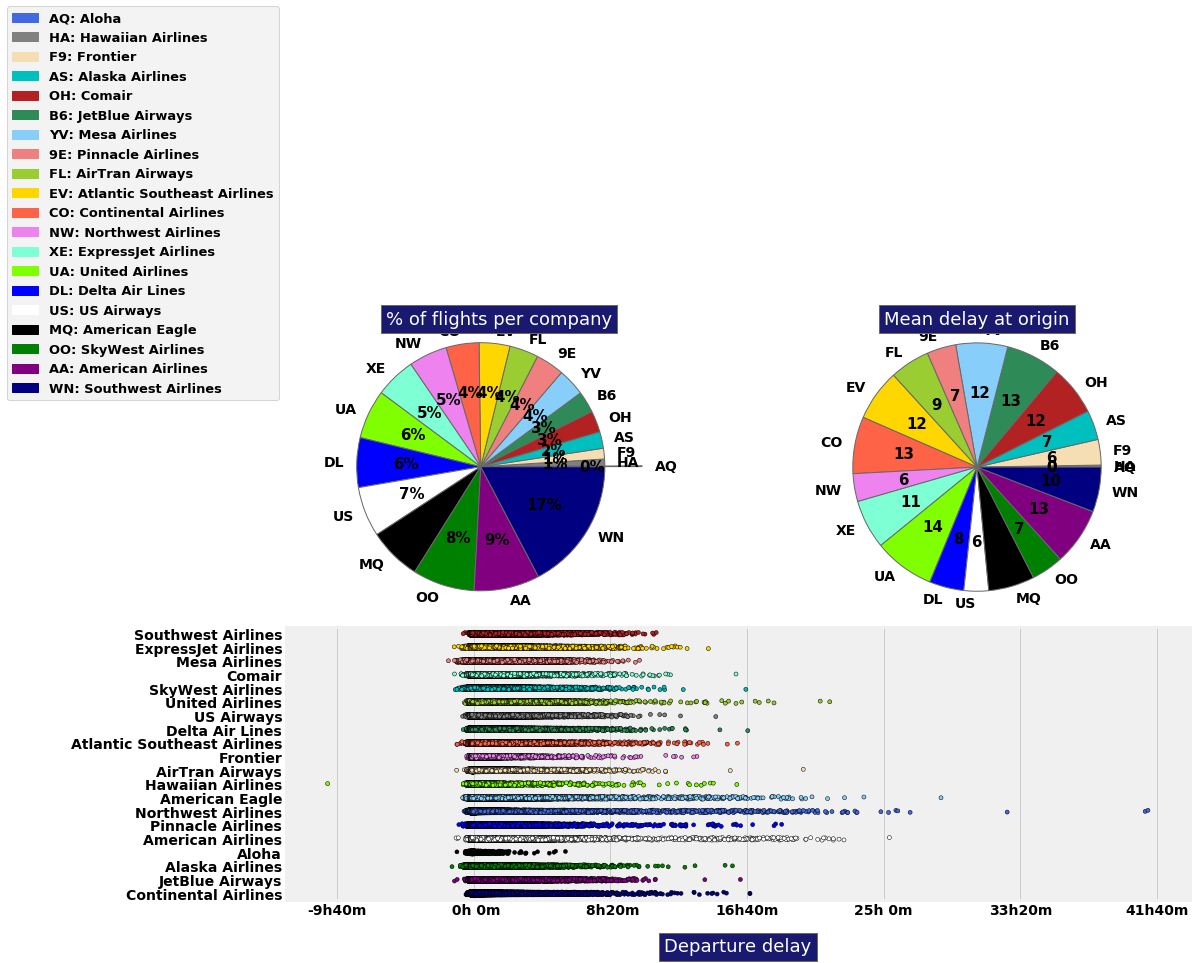

In [86]:
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
#__________________________________________________________________
# I extract a subset of columns and redefine the airlines labeling 
df2 = df.loc[:, ['UniqueCarrier', 'DepDelay']]
df2['UniqueCarrier'] = df2['UniqueCarrier'].replace(abbr_companies)
#________________________________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse',
          'blue', 'white', 'black', 'green', 'purple', 'navy']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(20)]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(20): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(20):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
           fontsize = 13, bbox_transform=plt.gcf().transFigure)
#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(20)]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(20): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)
#------------------------------------------------------
# striplot with all the values reported for the delays
#___________________________________________________________________
# I redefine the colors for correspondance with the pie charts
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue',
          'blue', 'white', 'black', 'green', 'purple', 'navy']
#___________________________________________________________________
ax3 = sns.stripplot(y='UniqueCarrier', x='DepDelay', size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3) 